In [1]:
from pyspark.conf import SparkConf 
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
from pyspark.sql import SparkSession
from datetime import datetime
from dateutil.parser import parse
import pyspark.sql.functions as f
from pyspark.sql.types import *
#from pyspark.sql.types import StructType,StructField, StringType, IntegerType
import pyspark
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import os
import findspark
findspark.find()
findspark.init(os.environ.get("$SPARK_HOME"))

## UserAgentParser
class UserAgentParser: 
    from user_agents import parse #// VERSION: 2.2.0
    from collections import namedtuple
    UA3Layers = namedtuple(typename='UA3Layers', field_names=['str_browser_name', 'str_operating_system_name', 'str_hardware_type_name'])
    
    class HardwareType:
        SERVER   = 'Server'
        TABLET   = 'Tablet'
        PHONE    = 'Phone'
        COMPUTER = 'Computer'
        OTHER    = 'Other'
        
    def get_3layers(self, str_user_agent):
        user_agent = self.__class__.parse(str_user_agent)
        return self.__class__.UA3Layers(self.get_browser_name(user_agent), self.get_operating_system_name(user_agent), self.get_hardware_type(user_agent))
    
    def get_browser_name(self, user_agent):
        """
        Return: ['Chrome', 'Firefox', 'Opera', 'IE', 'Edge', 'Safari', ...]
        변환로직:
            'IE Mobile' >>> 'IE'
            'Mobile Safari' >>> 'Safari'
        """
        str_browser_name = user_agent.browser.family
        str_browser_name = str_browser_name.replace('Mobile', '').strip()
        return str_browser_name
    
    def get_operating_system_name(self, user_agent):
        """
        Return: ['Windows','Linux','Mac OS X','iOS','Android','OpenBSD','BlackBerry OS','Chrome OS',...]
        """
        str_operating_system_name = user_agent.os.family
        return str_operating_system_name
    
    def get_hardware_type(self, user_agent):
        if user_agent.is_bot:
            str_hardware_type_name = self.__class__.HardwareType.SERVER
        elif user_agent.is_tablet:
            str_hardware_type_name = self.__class__.HardwareType.TABLET
        elif user_agent.is_mobile:
            str_hardware_type_name = self.__class__.HardwareType.PHONE
        elif user_agent.is_pc:
            str_hardware_type_name = self.__class__.HardwareType.COMPUTER
        else:
            str_hardware_type_name = self.__class__.HardwareType.OTHER
        return str_hardware_type_name


''' processing 단계: 
1. schema를 적용한 Dataframe 형태로 만들기

2. User Agents의 browser, OS, device 컬럼생성 및 기존컬럼제거

3. 발생할 수 있는 오류 확인 및 제거

4. row 제거 
- device를 기준으로 제거
- browser를 기준으로 제거
- os를 기준으로 제거

5. column 제거
- identifier 제거
- go-agent 제거
- protocol 제거

6. 변환
- 처리시간 변환
- 요청 시간을 datetime string으로 변환
- 형 변환
'''

' processing 단계: \n1. schema를 적용한 Dataframe 형태로 만들기\n\n2. User Agents의 browser, OS, device 컬럼생성 및 기존컬럼제거\n\n3. 발생할 수 있는 오류 확인 및 제거\n\n4. row 제거 \n- device를 기준으로 제거\n- browser를 기준으로 제거\n- os를 기준으로 제거\n\n5. column 제거\n- identifier 제거\n- go-agent 제거\n- protocol 제거\n\n6. 변환\n- 처리시간 변환\n- 요청 시간을 datetime string으로 변환\n- 형 변환\n'

In [4]:
# 1. schema를 이용한 dataframe 생성
columns=["IP","identifier","email","time","request","url","protocol","status_code",\
         "bytesize","referer","user-agent","go-agent","processing time"]

schema = StructType([ 
    StructField("IP", StringType(), True), 
    StructField("identifier", StringType(), True), 
    StructField("email", StringType(), True),
    StructField("time", StringType(), True),
    StructField("request", StringType(), True),
    StructField("url", StringType(), True),
    StructField("protocol", StringType(), True),
    StructField("status_code", StringType(), True),
    StructField("bytesize", StringType(), True),
    StructField("referer", StringType(), True),
    StructField("user-agent", StringType(), True),
    StructField("go-agent", StringType(), True),
    StructField("processing time", StringType(), True),
])

# 1. schema를 적용한 Dataframe 형태로 만들기
spark = pyspark.sql.SparkSession.builder.getOrCreate() # .master('local[*]')
web_log = spark.read.csv(f"hdfs://192.168.56.101:9000/web_log/log_01/access_2022-01-07.txt",  schema=schema)

## -------------------------------------------------------------------

In [5]:
# 2. User Agents의 browser, OS, device 컬럼생성 및 기존컬럼제거

def extract_browser(ua_string):
    userAgentParser = UserAgentParser()
    UA_info = userAgentParser.get_3layers(ua_string)
    return UA_info[0]

def extract_os(ua_string):
    userAgentParser = UserAgentParser()
    UA_info = userAgentParser.get_3layers(ua_string)
    return UA_info[1]

def extract_device(ua_string):
    userAgentParser = UserAgentParser()
    UA_info = userAgentParser.get_3layers(ua_string)
    return UA_info[2]

ext_browser_UDF = f.udf(lambda x: extract_browser(x))
ext_os_UDF = f.udf(lambda x: extract_os(x))
ext_device_UDF = f.udf(lambda x: extract_device(x))

web_log = web_log.withColumn("browser", ext_browser_UDF(f.col("user-agent")))
web_log = web_log.withColumn("os", ext_os_UDF(f.col("user-agent")))
web_log = web_log.withColumn("device", ext_device_UDF(f.col("user-agent")))
# web_log = web_log.drop("user-agent")

In [6]:
## -------------------------------------------------------------------

# 3. 발생할 수 있는 오류 확인 및 제거
web_log = web_log.filter((web_log.time  != "-") | (web_log.protocol  == "HTTP/1.0") | (web_log.protocol  == "HTTP/1.1"))

## -------------------------------------------------------------------

In [7]:
web_log.count()

1262905

In [8]:
pd_log = web_log.toPandas()

In [9]:
len(pd_log) # 총 개수 

1262905

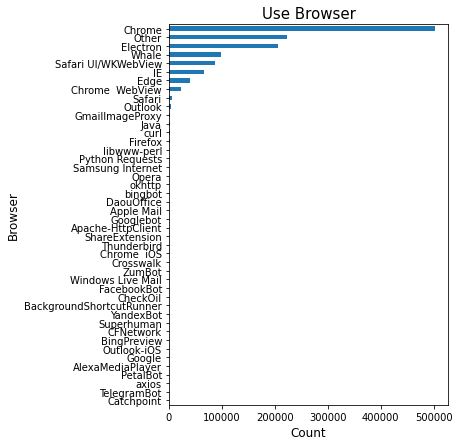

In [47]:
# browser
plt.rcParams["figure.figsize"] = (5,7)
plt.title("Use Browser", fontsize=15)
a = pd_log["browser"].value_counts(ascending=True)
a.plot.barh(width = 0.5)

plt.ylabel("Browser", fontsize=12)
plt.xlabel("Count", fontsize=12)
plt.show()

In [52]:
select_browser = ["Chrome",'Other', 'Whale', 'Safari UI/WKWebView', 'IE', 'Edge', 'Chrome WebView', 'Safari', 'Firefox', 'Outlook', 'Samsung Internet', 'Opera','Chrome iOS','Firefox iOS','Outlook-iOS']

# pd_log1 = pd_log[pd_log["browser"].isin(select_browser)]
pd_log1 =  pd_log[pd_log["browser"] != "Electron"]

In [54]:
len(pd_log1)

1056238

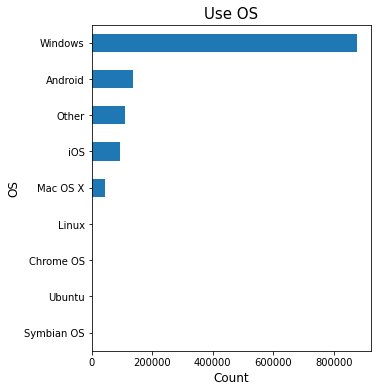

In [55]:
# os 
plt.rcParams["figure.figsize"] = (5,6)
plt.title("Use OS", fontsize=15)
pd_log["os"].value_counts(ascending=True).plot.barh(width = 0.5)

plt.ylabel("OS", fontsize=12)
plt.xlabel("Count", fontsize=12)
plt.show()

In [60]:
pd_log2 = pd_log1[pd_log1["os"] != "Other"]

In [61]:
len(pd_log2)

946983

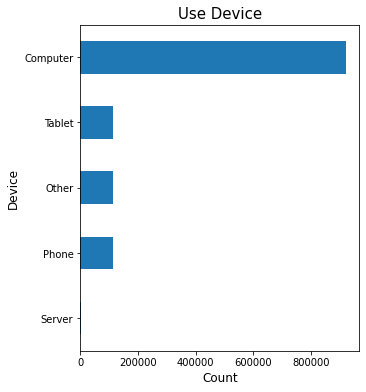

In [66]:
# device
plt.rcParams["figure.figsize"] = (5,6)
plt.title("Use Device", fontsize=15)
pd_log["device"].value_counts(ascending=True).plot.barh(width = 0.5)

plt.ylabel("Device", fontsize=12)
plt.xlabel("Count", fontsize=12)
plt.show()

In [24]:
pd_log3 = pd_log2[pd_log2["device"] == "Other"]

In [67]:
pd_log3 = pd_log2[pd_log2["device"] != "Other"]

In [68]:
len(pd_log3)  # 행의 개수가 약 0.25% 준다.

940603

In [16]:
# 4. row 제거

# device : bot ,개발과정에서 발생한 로그(크롤링, curl,Zabbix, okhttp 등) 제거 
web_log = web_log.filter((web_log.device  != "Bot") | (web_log.device  != "Other"))

# browser : 개발과정에서 발생한 로그 제외
select_browser = ["Chrome",'Other', 'Whale', 'Safari UI/WKWebView', 'IE', 'Edge', 'Chrome WebView', 'Safari', 'Firefox', 'Outlook', 'Samsung Internet', 'Opera','Chrome iOS','Firefox iOS','Outlook-iOS']
web_log = web_log.filter(web_log.browser.isin(select_browser))

# os : 알 수 없는 os, 개발과정에서 발생한 로그 제외
web_log = web_log.filter((web_log.os != "Other"))

In [38]:
# column 시각화
def s(x):
    if x == '-': return 'No Data'
    return x

pd_log3["identifier"] = pd_log3["identifier"].apply(lambda x : s(x))

/tmp/ipykernel_1896696/2982853604.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_log3["identifier"] = pd_log3["identifier"].apply(lambda x : s(x))


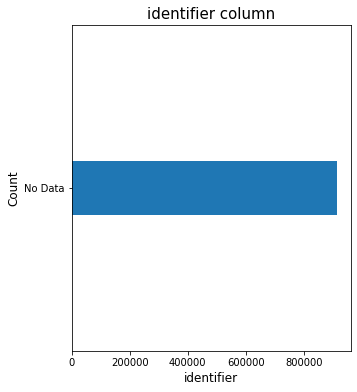

In [45]:
plt.rcParams["figure.figsize"] = (5,6)
plt.title("identifier column", fontsize=15)
pd_log3["identifier"].value_counts().plot.barh(width = 0.1)

plt.ylabel("Count", fontsize=12)
plt.xlabel("identifier", fontsize=12)
plt.show()

In [40]:
def s(x):
    if x == '-': return 'No Data'
    return x
    

pd_log3["go-agent"] = pd_log3["go-agent"].apply(lambda x : s(x))

/tmp/ipykernel_1896696/2571752654.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_log3["go-agent"] = pd_log3["go-agent"].apply(lambda x : s(x))


In [41]:
pd_log4 = pd_log3[pd_log3['go-agent'] != 'No Data']

In [46]:
pd_log3[pd_log3['go-agent'] != 'No Data']

,IP,identifier,email,time,request,url,protocol,status_code,bytesize,referer,user-agent,go-agent,processing time,browser,os,device
15,124.50.171.135,No Data,-,07/Jan/2022:00:00:07,GET,/api/device/version/check?deviceType=android&v...,HTTP/1.0,200,68,-,GO-Android/10.3.0.5,GO-Android,0.005,Other,Android,Tablet
18,124.50.171.135,No Data,run@daou.co.kr,07/Jan/2022:00:00:07,GET,/api/my/news,HTTP/1.0,200,224,-,GO-Android/10.3.0.5,GO-Android,0.085,Other,Android,Tablet
19,124.50.171.135,No Data,run@daou.co.kr,07/Jan/2022:00:00:08,GET,/api/mail/message/count?flag=U&folder=Inbox,HTTP/1.0,200,84,-,GO-Android/10.3.0.5,GO-Android,0.577,Other,Android,Tablet
22,124.50.171.135,No Data,run@daou.co.kr,07/Jan/2022:00:00:10,GET,/api/today/badge,HTTP/1.0,200,317,-,GO-Android/10.3.0.5,GO-Android,2.343,Other,Android,Tablet
30,112.186.58.216,No Data,cruiseny@daou.co.kr,07/Jan/2022:00:00:14,GET,/api/user/session,HTTP/1.0,200,835,https://portal.daou.co.kr/app/home,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,undefined,0.659,Chrome,Mac OS X,Computer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262885,110.11.144.79,No Data,yoonnoh546@daou.co.kr,07/Jan/2022:23:59:32,GET,/api/user/profile/4572,HTTP/1.0,200,3172,-,GO-Android/10.4.5.0,GO-Android,0.818,Other,Android,Tablet
1262886,110.11.144.79,No Data,-,07/Jan/2022:23:59:33,GET,//thumb/user/large/1446933-126584,HTTP/1.0,200,38589,-,GO-Android,GO-Android,0.02,Other,Android,Tablet
1262888,110.11.144.79,No Data,-,07/Jan/2022:23:59:41,GET,/api/device/version/check?deviceType=android&v...,HTTP/1.0,200,68,-,GO-Android/10.4.5.0,GO-Android,0.006,Other,Android,Tablet
1262891,110.11.144.79,No Data,yoonnoh546@daou.co.kr,07/Jan/2022:23:59:49,GET,/api/user/profile/4912,HTTP/1.0,200,3112,-,GO-Android/10.4.5.0,GO-Android,0.739,Other,Android,Tablet


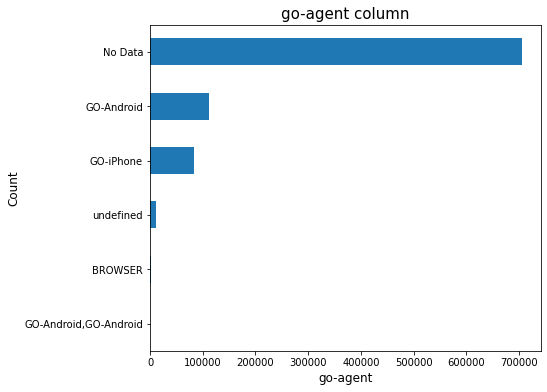

In [42]:
plt.rcParams["figure.figsize"] = (7,6)
plt.title("go-agent column", fontsize=15)
pd_log3["go-agent"].value_counts(ascending=True).plot.barh(width = 0.5)

plt.ylabel("Count", fontsize=12)
plt.xlabel("go-agent", fontsize=12)
plt.show()

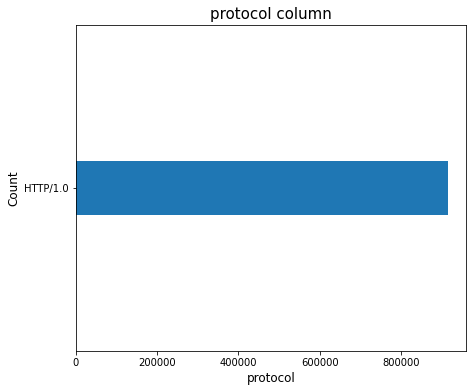

In [43]:
plt.rcParams["figure.figsize"] = (7,6)
plt.title("protocol column", fontsize=15)
pd_log3["protocol"].value_counts(ascending=True).plot.barh(width = 0.1)

plt.ylabel("Count", fontsize=12)
plt.xlabel("protocol", fontsize=12)
plt.show()

In [ ]:
## -------------------------------------------------------------------

# 5. column 제거

# identifier : identifier count 0
web_log = web_log.drop("identifier")

# go-agent :  user-agent의 (browser, os, device)를 파악함으로써 go-agent의 정보를 대체할 수 있다.
web_log = web_log.drop("go-agent")

# protocol : http/1.0으로 중복, status_code를 통하여 http/1.0 protocol를 유추가능
web_log = web_log.drop("protocol")

## -------------------------------------------------------------------

In [14]:
# 6. 처리시간 변환
web_log = web_log.withColumn('processing time',\
                     f.when(web_log["processing time"].isin('-'),f.regexp_replace(web_log["processing time"],'-',''))\
                     .otherwise(web_log["processing time"]))

# 6. 요청 시간을 datetime string으로 변환
def trans_time(t):
    return str(pd.to_datetime(t,format='%d/%b/%Y:%H:%M:%S'))

time_UDF = f.udf(lambda x: trans_time(x))

web_log = web_log.withColumn("datetime", time_UDF(f.col("time")))
web_log = web_log.drop("time")


# 6. type 변환 (int, float, timestamp)
web_log = web_log.withColumn('bytesize',\
                     f.when(web_log["bytesize"].isin('-'),f.regexp_replace(web_log["bytesize"],'-','0')) .otherwise(web_log["bytesize"]))
web_log = web_log.withColumn("bytesize", web_log["bytesize"].cast(IntegerType()))                     

web_log = web_log.withColumn('processing time',\
                     f.when(web_log["processing time"].isin('-'),f.regexp_replace(web_log["processing time"],'-','0')) .otherwise(web_log["processing time"]))
web_log = web_log.withColumn("processing time", web_log["processing time"].cast(FloatType()))                

web_log = web_log.withColumn("datetime",f.to_timestamp("datetime"))

In [3]:
#             # PostgreSQL 적재 
#             web_log.write.mode("append").jdbc("jdbc:postgresql://localhost:5432/superset", f"public.admin{idx}",\
#                                           properties={"user": "postgres", "password": "1234"})

'''Pandas processing'''
# ''' processing : 
# 1. 읽은 파일을 데이터 프레임으로 변환
# 2. 컬럼 제거 / 제거기준 : "+0900", 클라이언트 식별자, 프로토콜 ,go-agent 식별정보
# 3. email -> userid를 뽑아내기
# 4. 요청 시간 -> datetime형태로 변환
# 5. UA -> browser, OS, device -> 기존컬럼제거
# 6  요청처리시간 오류 제거
# 7. int형태로 변환
# '''
    
# #  bite가 얼마나 줄었는지 생각하기 (size줄이기)
# #  postgreSQL에 적재할 테이블 기준생성
# #  ip/사용자아이디/요청 시간/요청 페이지/HTTP상태코드/바이트사이즈/레퍼러/요청처리시간/요청처리시간/브라우저/OS/장치 (13개컬럼)
# log = ['172.21.27.94 - cabeza_@daou.co.kr [17/Mar/2022:08:56:34 +0900] GET /api/chat/rooms/93730?size=21&userSeq=3012 HTTP/1.0 200 1757 "-" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) DaouMessenger/3.5.0 Chrome/91.0.4472.164 Electron/13.5.2 Safari/537.36" "GO-PC" 0.081',
# '112.168.170.128 - jieun.kim@daou.co.kr [17/Mar/2022:08:56:34 +0900] GET /api/approval/todo/count HTTP/1.0 200 224 "https://portal.daou.co.kr/app/approval/document/534993/integration" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.74 Safari/537.36" "-" 0.129',
# '112.168.170.128 - jieun.kim@daou.co.kr [17/Mar/2022:08:56:34 +0900] GET /api/approval/document/534993 HTTP/1.0 200 6314 "https://portal.daou.co.kr/app/approval/document/534993/integration" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.74 Safari/537.36" "-" 0.169',
# '123.2.134.129 - - [17/Mar/2022:08:57:02 +0900] GET /go/login HTTP/1.0 200 10162 "-" "Zabbix" "-" 0.015',
# '123.2.134.129 - - [17/Mar/2022:08:58:02 +0900] GET /go/login HTTP/1.0 200 10162 "-" "Zabbix" "-" 0.023',
# '123.2.134.129 - - [17/Mar/2022:08:59:04 +0900] GET /go/login HTTP/1.0 200 10162 "-" "Zabbix" "-" 0.017',
# '- - - [17/Mar/2022:08:59:29 +0900] GET / HTTP/1.1 302 - "-" "libwww-perl/5.822" "-" 0.019']

# columns = ["ip","user_id","datetime","request","url","status","bytesize","refferer","processing time", "browser", "OS", "device"]
# r= []
# def trans_email(t):
#     row[1] = t.split("@")[0]
    
# def extract_UAinfo(ua_string):
#     userAgentParser = UserAgentParser()
#     UA_info = userAgentParser.get_3layers(ua_string)
#     return [UA_info[0],UA_info[1],UA_info[2]]

# def trans_time(t):
#     print(type(str(pd.to_datetime(t,format='%d/%b/%Y:%H:%M:%S'))))
#     row[2] = pd.to_datetime(t,format='%d/%b/%Y:%H:%M:%S')

# for s in log:
#     s = s.replace('[', '"').replace(']','"')
#     s =s.split('"')

#     # 1. dataframe 만들기
#     row, tmp = [], []
#     for i in s:
#         if i==' ':
#             continue
#         i = i.strip()
#         tmp.append(i)

#     for i in tmp[:3]:
#         row += i.split()
#     row += tmp[3:]

#     # 2. 컬럼제거
#     del row[1]
#     del row[3]
#     del row[5]
#     del row[9]

#     # 3. email -> userid를 뽑아내기
#     trans_email(row[1])

#     # 4. 요청 시간 -> datetime형태로 변환
#     trans_time(row[2])

#     # 5. UA -> browser, OS, device -> 기존컬럼제거
#     row += extract_UAinfo(row[8])
#     del row[8]

#     # 6. 요청처리시간 오류 제거
#     row[8] = re.sub("-","",row[8])

#     # 7. int형태로 변환
#     if row[6] != '-':
#         row[6] = int(row[6])
#         row[8] = float(row[8])
        
#     r.append(row)


# df = pd.DataFrame(r, columns = columns)  
# df

s= '123425525asdf'
s[-4:-2]

In [9]:
schema = StructType([ 
    StructField("IP", StringType(), True), 
    StructField("email", StringType(), True),
    StructField("request", StringType(), True),
    StructField("url", StringType(), True),
    StructField("status_code", StringType(), True),
    StructField("bytesize", IntegerType(), True),
    StructField("referer", StringType(), True),
    StructField("processing time", FloatType(), True),
    StructField("browser", StringType(), True),
    StructField("os", StringType(), True),
    StructField("device", StringType(), True),
    StructField("datetime", TimestampType(), True),
])
web_log = spark.read.csv(f"hdfs://192.168.56.101:9000/admin_log//log_01_final/access_2022-01-02.txt", schema=schema)

In [12]:
web_log.show(10)

+------------+--------------------+-------+--------------------+-----------+--------+--------------------+---------------+-------+-------+--------+-------------------+
|          IP|               email|request|                 url|status_code|bytesize|             referer|processing time|browser|     os|  device|           datetime|
+------------+--------------------+-------+--------------------+-----------+--------+--------------------+---------------+-------+-------+--------+-------------------+
|172.21.24.71|                   -|    GET|   /go/admin/company|        302|       0|                   -|          0.031|     IE|Windows|Computer|2022-01-02 07:12:45|
|172.21.24.71|                   -|    GET|/go/login?returnU...|        200|    2801|                   -|          0.033|     IE|Windows|Computer|2022-01-02 07:12:45|
|172.21.24.71|                   -|    GET|/go/ad/api/login/...|        200|     190|https://portal.da...|          0.012|     IE|Windows|Computer|2022-01-02 07